In [ ]:
!git clone https://github.com/Lhyejin/LaneNet-PyTorch.git

Cloning into 'LaneNet-PyTorch'...
remote: Enumerating objects: 191, done.
remote: Counting objects: 100% (191/191), done.
remote: Compressing objects: 100% (156/156), done.
remote: Total 191 (delta 55), reused 154 (delta 27), pack-reused 0
Receiving objects: 100% (191/191), 29.32 MiB | 30.08 MiB/s, done.
Resolving deltas: 100% (55/55), done.


In [ ]:
%cd LaneNet-PyTorch//
!ls
!pip install -r requirements.txt

/content/LaneNet-PyTorch
dataset  LICENSE	      requirements.txt	Train.ipynb
img	 Notebook-experiment  test.py		TUSIMPLE
Lanenet  README.md	      Train_aug.ipynb	utils


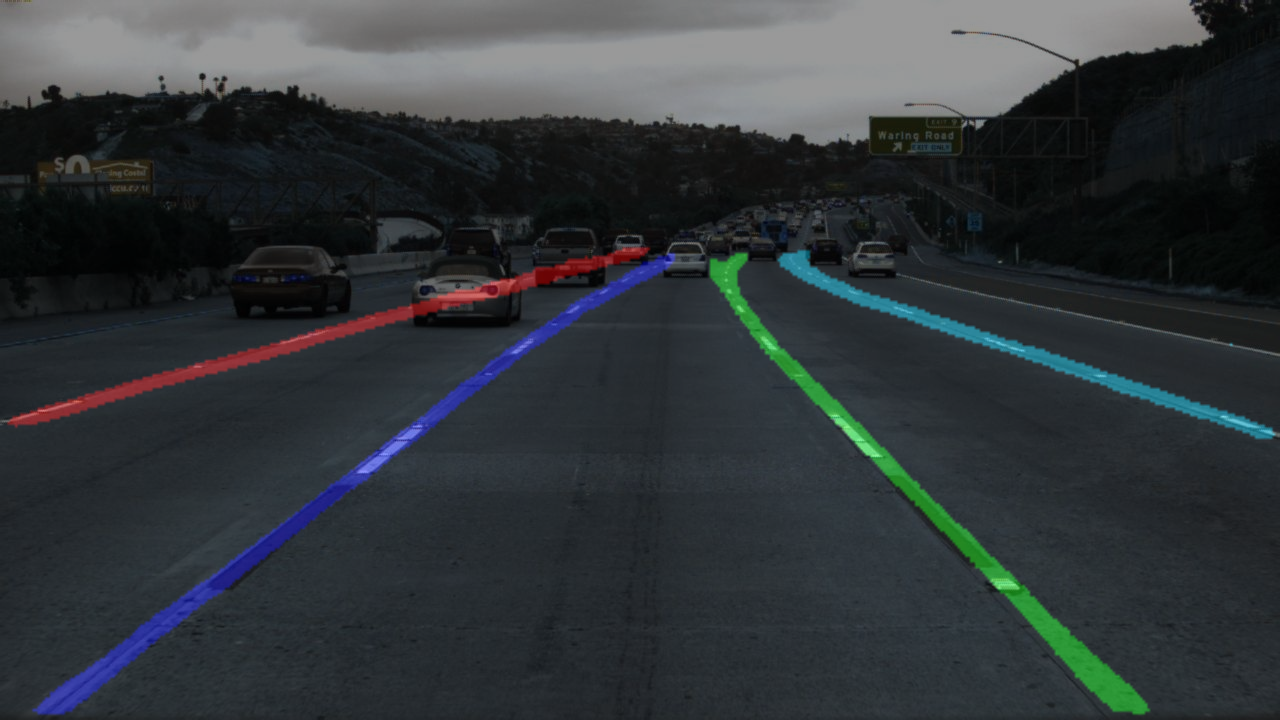

In [ ]:
import os.path as ops
import numpy as np
import torch
import cv2
import time
import os
import matplotlib.pylab as plt
import sys
from tqdm import tqdm
import imageio
from dataset.dataset_utils import TUSIMPLE
from Lanenet.model2 import Lanenet
from utils.evaluation import gray_to_rgb_emb, process_instance_embedding
from google.colab.patches import cv2_imshow

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the Model
model_path = './TUSIMPLE/Lanenet_output/lanenet_epoch_39_batch_8.model'
LaneNet_model = Lanenet(2, 4)
LaneNet_model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
LaneNet_model.to(device)

def inference(gt_img_org):
    # BGR 순서
    org_shape = gt_img_org.shape
    gt_image = cv2.resize(gt_img_org, dsize=(512, 256), interpolation=cv2.INTER_LINEAR)
    gt_image = gt_image / 127.5 - 1.0
    gt_image = torch.tensor(gt_image, dtype=torch.float)
    gt_image = np.transpose(gt_image, (2, 0, 1))
    gt_image = gt_image.to(device)
    # lane segmentation 
    binary_final_logits, instance_embedding = LaneNet_model(gt_image.unsqueeze(0))
    binary_final_logits, instance_embedding = binary_final_logits.to('cpu'), instance_embedding.to('cpu') 
    binary_img = torch.argmax(binary_final_logits, dim=1).squeeze().numpy()
    binary_img[0:65,:] = 0

    # lane clustering & segemented frame embedding
    rbg_emb, cluster_result = process_instance_embedding(instance_embedding, binary_img,
                                                          distance=1.5, lane_num=4)

    rbg_emb = cv2.resize(rbg_emb, dsize=(org_shape[1], org_shape[0]), interpolation=cv2.INTER_LINEAR)
    a = 0.6
    frame = a * gt_img_org[..., ::-1] / 255 + rbg_emb * (1 - a)
    frame = np.rint(frame * 255)
    frame = frame.astype(np.uint8)

    return frame


image = cv2.imread('TUSIMPLE/test_clips/1494452927854312215/1.jpg')
cv2_imshow(inference(image))

In [ ]:
def video2segemented_video(video_path):
    # Remove exist output video
    try:
        os.remove('./output.mp4')
    except FileNotFoundError:
        print("Couldn't found a exist data")

    # TODO: video to frames
    captured_video = cv2.VideoCapture(video_path)

    if not captured_video.isOpened():
        print("Failed to open video. Exit the function")
        return
    
    # Remove exist video frames
    try:
        import shutil
        shutil.rmtree('./capturedframe')
    except FileNotFoundError:
         print("Exist frames not found")
    finally:
        os.mkdir('./capturedframe')

    # TODO: extract lane from frame
    framecount = 0

    while True:
        print("Inference count:", framecount)
        ret, frame = captured_video.read()

        if not ret:
            break

        frame_name = './capturedframe/' + str(framecount) + '.jpg'
        cv2.imwrite(frame_name, inference(frame))
        framecount += 1
        # Fix fps to 25
        cv2.waitKey(40)      

    # TODO: frames to video & store video
    print("Make a output video")
    img_ar = []

    for i in range(framecount):
        img = cv2.imread('./capturedframe/' + str(i) + '.jpg')
        height, width, layers = img.shape
        img_size = (width, height)
        img_ar.append(img)

    out = cv2.VideoWriter(
            './output.mp4',
            cv2.VideoWriter_fourcc(*'DIVX'),
            25,
            img_size
          )
    
    for j in img_ar:
        out.write(j)

    captured_video.release()
    out.release()
    cv2.destroyAllWindows()
    print("Finished")

In [ ]:
# Test
video_path = "./vid/target.mp4" # input your video path
video2segemented_video(video_path)

Inference count: 0
Inference count: 1
Inference count: 2
Inference count: 3
Inference count: 4
Inference count: 5
Inference count: 6
Inference count: 7
Inference count: 8
Inference count: 9
Inference count: 10
Inference count: 11
Inference count: 12
Inference count: 13
Inference count: 14
Inference count: 15
Inference count: 16
Inference count: 17
Inference count: 18
Inference count: 19
Inference count: 20
Inference count: 21
Inference count: 22
Inference count: 23
Inference count: 24
Inference count: 25
Inference count: 26
Inference count: 27
Inference count: 28
Inference count: 29
Inference count: 30
Inference count: 31
Inference count: 32
Inference count: 33
Inference count: 34
Inference count: 35
Inference count: 36
Inference count: 37
Inference count: 38
Inference count: 39
Inference count: 40
Inference count: 41
Inference count: 42
Inference count: 43
Inference count: 44
Inference count: 45
Inference count: 46
Inference count: 47
Inference count: 48
Inference count: 49
Inference 